In [908]:
import numpy as np
from numpy.linalg import inv
from ott.geometry.costs import SqEuclidean
from scipy.stats import norm, uniform

import matplotlib.pyplot as plt

In [909]:
np.random.seed(5)

num_a = 100
num_b = 75
num_blocked_pairs = 2 * (num_a + num_b)

num_iters = int(1e3)

In [910]:
gamma_0 = 10.0 # regularisation
gamma_c = 15.0 # column constraints
gamma_r = 15.0 # row constraints

# select which constraints to enforce
rows_to_relax = np.random.choice([0,1], size=(num_a,1), p=[0.75,0.25])
cols_to_relax = np.random.choice([0,1], size=(1,num_b), p=[0.75,0.25])

row_exponent_0 = gamma_r/(1+gamma_r) * rows_to_relax
row_exponent_0[rows_to_relax == 0] = 1.0
row_exponent_1 = rows_to_relax * (-1/gamma_r) # 1s are implicit here

col_exponent_0 = gamma_c/(1+gamma_c) * cols_to_relax
col_exponent_0[cols_to_relax == 0] = 1.0
col_exponent_1 = cols_to_relax * (-1/gamma_c) # 1s are implicit here

In [911]:
# locs
a = np.arange(num_a)# * (num_b / num_a)
b = np.arange(num_b)

# weights 
# mu = norm.pdf(a, loc=(3/8) * num_a, scale=5.0)
mu = np.random.normal(loc=5.0, scale=1.0, size=a.shape[0])
# mu /= np.sum(mu)
mu_0 = mu.copy()

# nu = norm.pdf(b, loc=num_b/2, scale=7.5) 
nu = np.random.normal(loc=7.0, scale=1.5, size=b.shape[0])
# nu /= np.sum(nu)
nu_0 = nu.copy()

In [912]:
print(mu.shape, nu.shape)
print(np.sum(mu), np.sum(nu))

(100,) (75,)
509.19772413490045 517.8870749262747


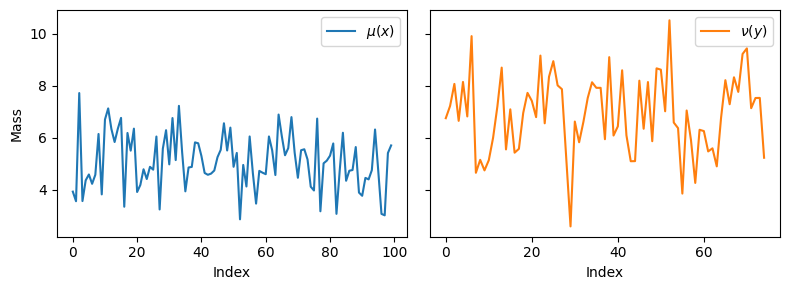

In [913]:
fig, axs = plt.subplots(1,2, sharey='all', figsize=(8,3))

axs[0].plot(a, mu_0, label=r'$\mu(x)$', c='tab:blue')
axs[1].plot(b, nu_0, label=r'$\nu(y)$', c='tab:orange')

axs[0].set_xlabel('Index')
axs[1].set_xlabel('Index')
axs[0].set_ylabel('Mass')

axs[0].legend()
axs[1].legend()
fig.tight_layout()

In [914]:
# cost fn
# C = SqEuclidean().all_pairs(a.reshape(-1,1), b.reshape(-1,1))
C = np.random.random(size=(num_a, num_b)) ** 2

# kernel
K = np.pow(np.e, -C / gamma_0)

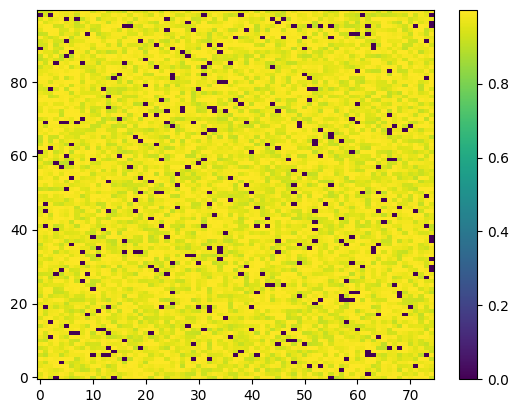

In [915]:
# choose which index pairs to block
l_idxs_x = np.random.choice(np.arange(a.shape[0]), num_blocked_pairs)
l_idxs_y = np.random.choice(np.arange(b.shape[0]), num_blocked_pairs)
K[l_idxs_x, l_idxs_y] = 0

plt.pcolormesh(b, a, K)
plt.colorbar()

## No Relaxation of Marginals

169.07381999889608


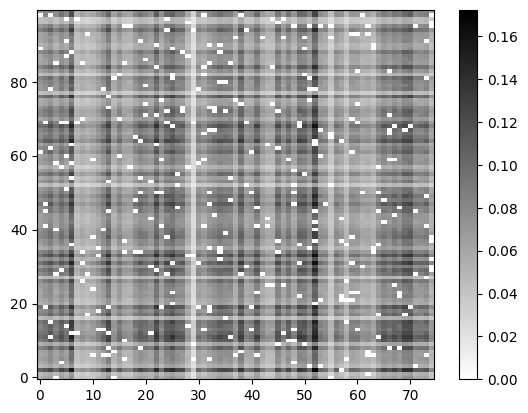

In [916]:
T = K.copy()

for i in range(num_iters):
    T *= np.divide(mu[:,None], np.sum(T, axis=1, keepdims=True), out=np.ones_like(T), where=(T != 0.0))
    T *= np.divide(nu[None,:], np.sum(T, axis=0, keepdims=True), out=np.ones_like(T), where=(T != 0.0))

plt.pcolormesh(b, a, T, shading="auto", cmap="gray_r")
plt.colorbar()
print(np.sum(np.multiply(T, C)))

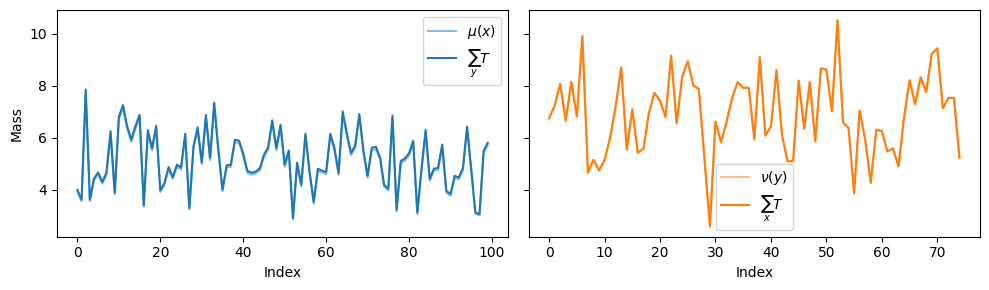

In [917]:
fig, axs = plt.subplots(1,2, sharey='all', figsize=(10,3))

axs[0].plot(a, mu_0, label=r'$\mu(x)$', c='tab:blue', alpha=0.5)
axs[1].plot(b, nu_0, label=r'$\nu(y)$', c='tab:orange', alpha=0.5)

axs[0].plot(a, np.sum(T, axis=1), label=r'$\sum_y  T$', c='tab:blue')
axs[1].plot(b, np.sum(T, axis=0), label=r'$\sum_x  T$', c='tab:orange')


axs[0].set_xlabel('Index')
axs[1].set_xlabel('Index')
axs[0].set_ylabel('Mass')

axs[0].legend()
axs[1].legend()
fig.tight_layout()

## Marginals Selectively Relaxed

171.85273561526907


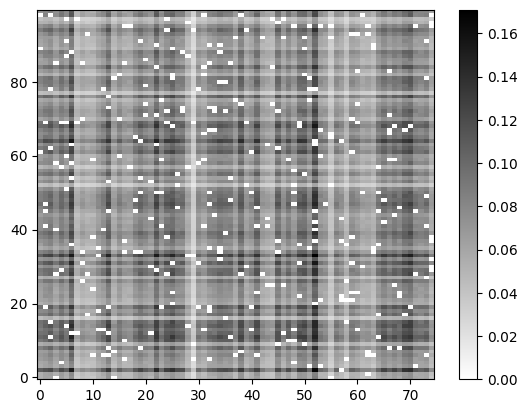

In [918]:
T = K.copy()
T_old = K.copy()

convergence_list = np.zeros(shape=(num_iters))


for i in range(num_iters):
    D1 = np.divide(mu[:,None], np.sum(T, axis=1, keepdims=True), out=np.ones_like(mu[:,None]), where=(np.sum(T, axis=1, keepdims=True) != 0.0))
    D1 = np.pow(D1, row_exponent_0)
    T = D1 * T
    mu = (np.pow(D1, row_exponent_1) * mu[:,None]).reshape(-1,)

    D2 = np.divide(nu[None,:], np.sum(T, axis=0, keepdims=True), out=np.ones_like(nu[None,:]), where=(np.sum(T, axis=0, keepdims=True) != 0.0))
    D2 = np.pow(D2, col_exponent_0)
    T = D2 * T
    nu = (np.pow(D2, col_exponent_1) * nu[None,:]).reshape(-1,)

    convergence_list[i] = np.linalg.norm((T - T_old).ravel(), ord=1)
    T_old = T.copy()
    

plt.pcolormesh(b, a, T, shading="auto", cmap="gray_r")
plt.colorbar()
print(np.sum(np.multiply(T, C)))

Text(0, 0.5, 'Change in T')

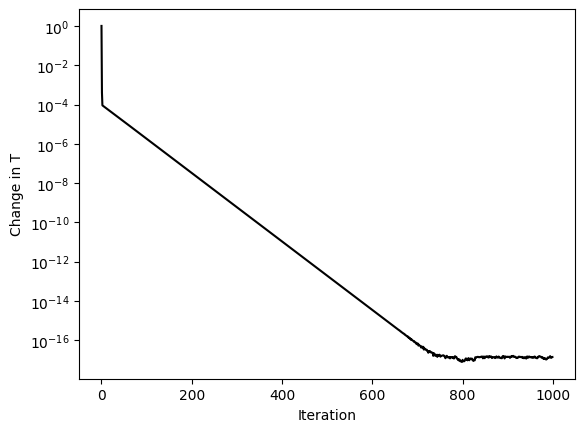

In [919]:
fig, ax = plt.subplots()

ax.plot(convergence_list / convergence_list[0], c='k')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Change in T')

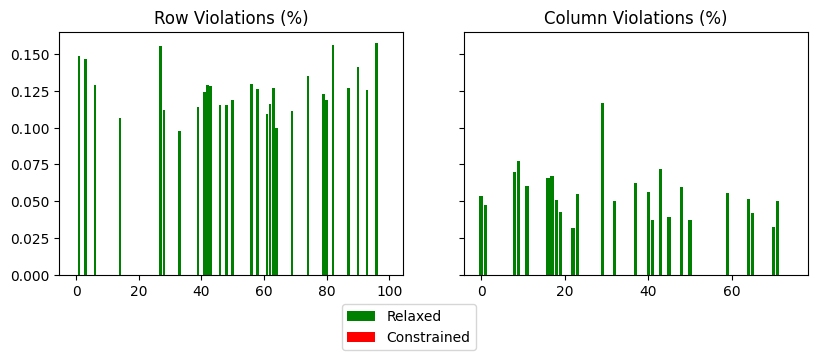

In [920]:
from matplotlib.patches import Patch

# fig, (ax_r, ax_c) = plt.subplots(1,2, figsize=(8,4))
fig, (ax_r, ax_c) = plt.subplots(1,2, figsize=(9,4), sharey='row')

def binary_to_colour(arr):
    colours = np.array(arr, dtype=str)
    colours[arr == 1] = 'green'
    colours[arr == 0] = 'red'
    return colours

ax_r.bar(x=np.arange(num_a), height=np.abs(mu_0 - np.sum(T, axis=1)) / mu_0, color=binary_to_colour(rows_to_relax.reshape(-1,)))
ax_r.set_title('Row Violations (%)')

ax_c.bar(x=np.arange(num_b), height=np.abs(nu_0 - np.sum(T, axis=0)) / nu_0, color=binary_to_colour(cols_to_relax.reshape(-1,)))
ax_c.set_title('Column Violations (%)')

fig.tight_layout(pad=4)
fig.legend(labels=['Relaxed', 'Constrained'], handles=[Patch(facecolor='green'), Patch(facecolor='red')], loc='outside lower center')


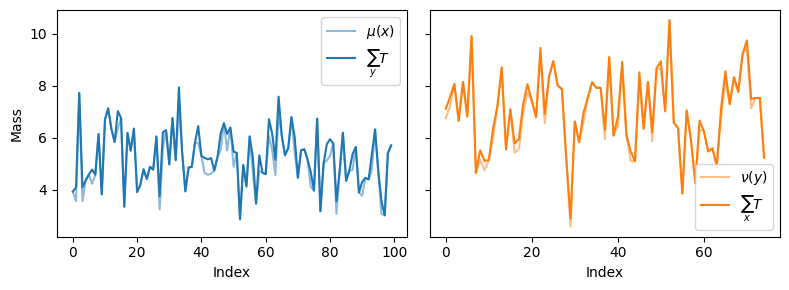

In [921]:
fig, axs = plt.subplots(1,2, sharey='all', figsize=(8,3))

axs[0].plot(a, mu_0, label=r'$\mu(x)$', c='tab:blue', alpha=0.5)
axs[1].plot(b, nu_0, label=r'$\nu(y)$', c='tab:orange', alpha=0.5)

axs[0].plot(a, np.sum(T, axis=1), label=r'$\sum_y  T$', c='tab:blue')
axs[1].plot(b, np.sum(T, axis=0), label=r'$\sum_x  T$', c='tab:orange')

axs[0].set_xlabel('Index')
axs[1].set_xlabel('Index')
axs[0].set_ylabel('Mass')

axs[0].legend()
axs[1].legend()
fig.tight_layout()

# Domain Adaptation Example

In [922]:
gamma_0 = 0.5 # regularisation
gamma_c = 10.0 # column constraints
gamma_r = 10.0 # row constraints

num_a = 150
num_b = 250
num_iters = int(1e3)

In [923]:
# locs
a = np.arange(num_a)
b = np.arange(num_b)

# weights 
mu = np.ones_like(a, dtype=np.float64)
# mu /= np.sum(mu)
mu_0 = mu.copy()

nu = np.ones_like(b, dtype=np.float64)
# nu /= np.sum(nu)
nu_0 = nu.copy()

# classes
a_cls = np.random.choice(6, size=(num_a,), p=[0.15, 0.15, 0.2, 0.2, 0.1, 0.2])
# b_cls = np.random.choice(6, size=(num_b,), p=[0.15, 0.15, 0.2, 0.2, 0.1, 0.2])
b_cls = np.random.choice(6, size=(num_b,), p=[0.1, 0.2, 0.05, 0.1, 0.05, 0.5])

# costs
C = 5 * (np.random.random(size=(num_a, num_b)) + (a_cls[:,None] != b_cls[None,:]))
C -= (a_cls[:,None] == np.max(a_cls)) 
C -= (b_cls[None,:] == np.max(b_cls))

K = np.pow(np.e, -C / gamma_0)

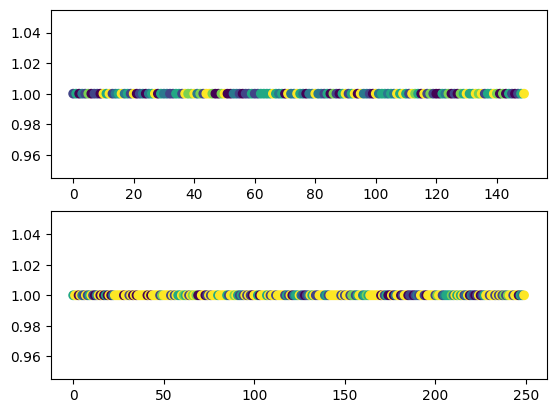

In [924]:
fig, axs = plt.subplots(2)

axs[0].scatter(a, mu, c=a_cls)
axs[1].scatter(b, nu, c=b_cls)

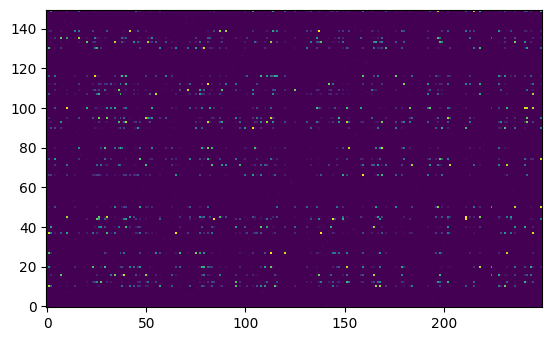

In [925]:
# constraints
rows_to_relax = np.where(a_cls == np.max(a_cls))[0]
cols_to_relax = np.where(b_cls == np.max(b_cls))[0]
blocked_correspondences = {0: [4], 1: [3], 2: [], 3: [], 4: [1, 2]}

for i, row in enumerate(K):
    if i in rows_to_relax: continue # if class is unknown, no zero blocks

    for j, col in enumerate(row):
        if j in cols_to_relax: continue # if class is unknown, no zero blocks

        elif int(b_cls[j]) in blocked_correspondences[int(a_cls[i])]:
            K[i,j] = 0.0

row_exponent_0 = gamma_r/(1+gamma_r) * np.ones((num_a,1))
row_exponent_0[rows_to_relax,:] = 1.0
row_exponent_1 = (a_cls == np.max(a_cls))[:,None] * (-1/gamma_r) # 1s are implicit here

col_exponent_0 = gamma_c/(1+gamma_c) * np.ones((1,num_b))
col_exponent_0[:,cols_to_relax] = 1.0
col_exponent_1 = (b_cls == np.max(b_cls))[None,:] * (-1/gamma_c) # 1s are implicit here

ax = plt.gca()
ax.pcolormesh(b, a, K)
ax.set_aspect('equal', 'box')

94.42670962286438


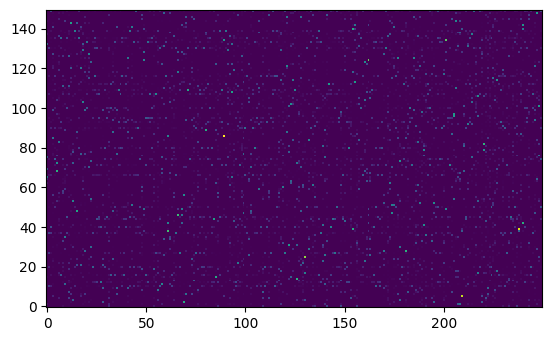

In [926]:
T = K.copy()
T_old = T.copy()
convergence_list = np.zeros(shape=(num_iters))

for i in range(num_iters):
    D1 = np.divide(mu[:,None], np.sum(T, axis=1, keepdims=True))
    D1 = np.pow(D1, row_exponent_0)
    T = D1 * T
    mu = (np.pow(D1, row_exponent_1) * mu[:,None]).reshape(-1,)

    D2 = np.divide(nu[None,:], np.sum(T, axis=0, keepdims=True))
    D2 = np.pow(D2, col_exponent_0)
    T = D2 * T
    nu = (np.pow(D2, col_exponent_1) * nu[None,:]).reshape(-1,)

    convergence_list[i] = np.linalg.norm((T - T_old).ravel(), ord=1)
    T_old = T.copy()

ax = plt.gca()
ax.pcolormesh(b, a, T)
ax.set_aspect('equal', 'box')
print(np.sum(np.multiply(T, C)))

Text(0, 0.5, 'Change in T')

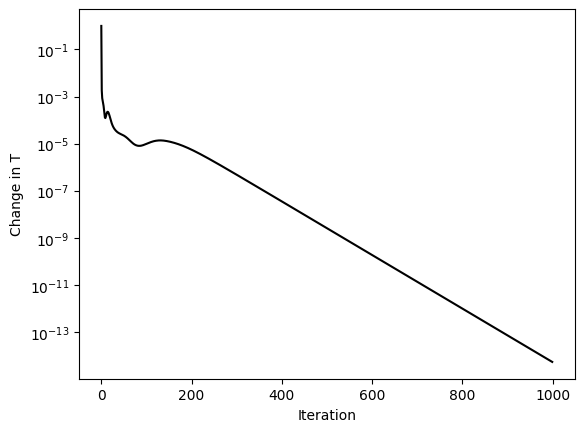

In [927]:
fig, ax = plt.subplots()

ax.plot(convergence_list / convergence_list[0], c='k')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Change in T')

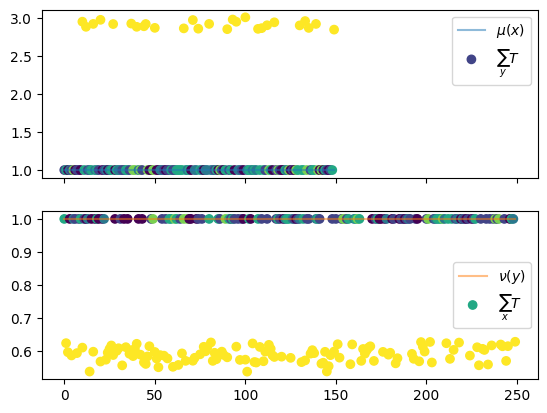

In [928]:
fig, axs = plt.subplots(2, sharex='all')

axs[0].plot(a, mu_0, label=r'$\mu(x)$', c='tab:blue', alpha=0.5)
axs[1].plot(b, nu_0, label=r'$\nu(y)$', c='tab:orange', alpha=0.5)

# axs[0].scatter(a, mu, c=a_cls)
# axs[1].scatter(b, nu, c=b_cls)
axs[0].scatter(a, np.sum(T, axis=1), label=r'$\sum_y  T$', c=a_cls)
axs[1].scatter(b, np.sum(T, axis=0), label=r'$\sum_x  T$', c=b_cls)

axs[0].legend()
axs[1].legend()